# Step 1: Importing Essential Libraries

In [9]:
import pandas as pd  # Importing pandas for data manipulation and analysis.
import numpy as np  # Importing numpy for numerical computations.
import warnings  # Importing warnings to control warning messages.
warnings.filterwarnings('ignore')  # Suppresses unnecessary warnings for a cleaner output.


# Step 2: Loading data and Making labels

In [10]:
df = pd.read_csv("hmnist_28_28_RGB.csv")  # Loading the dataset from a CSV file.
df.tail()  # Displaying the last 5 rows of the dataframe to verify loading.


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,...,159,79,82,174,137,125,175,139,126,6


# Step 3: Train Test Split

In [11]:
fractions = np.array([0.8, 0.2]) # Defines proportions for training and testing splits.

df = df.sample(frac=1)           # Randomly shuffles the dataset for unbiased splitting.

train_set, test_set = np.array_split(df, (fractions[:-1].cumsum() * len(df)).astype(int))
# Splits the dataset into training and testing sets based on defined fractions.


In [12]:
print(len(train_set))  # Printing the size of the training set.
print(len(test_set))  # Printing the size of the test set.

8012
2003


In [13]:
df.label.unique()  # Displaying unique labels in the dataset to understand class distribution.

array([4, 6, 2, 0, 1, 3, 5])

In [14]:
# Creating a dictionary to map numeric labels to descriptive class names.
classes = {
    0: ('akiec', 'actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma'),
}


In [15]:
y_train = train_set['label']  # Extracting labels for the training set.
x_train = train_set.drop(columns=['label'])  # Removing label column from training features.
y_test = test_set['label']  # Extracting labels for the test set.
x_test = test_set.drop(columns=['label'])  # Removing label column from test features.
columns = list(x_train)  # Getting a list of feature column names.

In [16]:
import torch  # Importing PyTorch for GPU/CPU usage.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Selecting device based on availability.
print(device)  # Printing the selected device.

cpu


# Step 4: Exploratory Data Analysis and Preprocessing

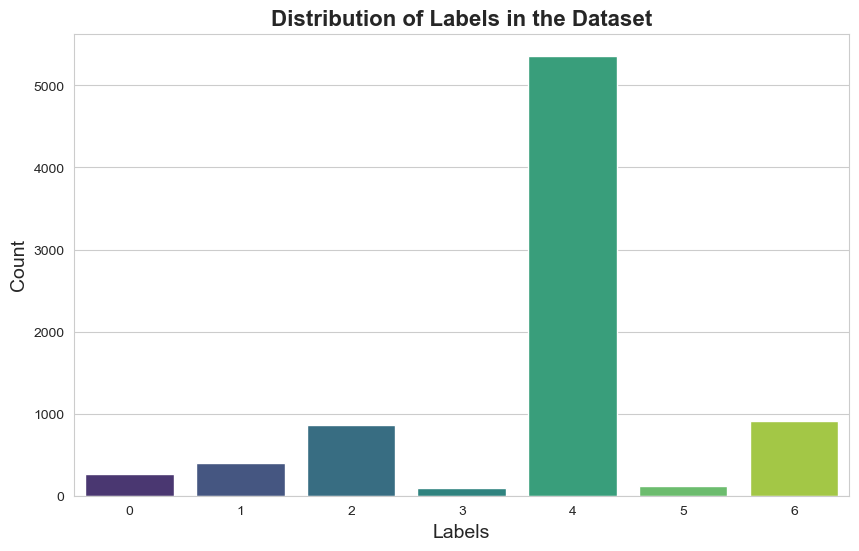

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizing class distribution in the training set.
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x=train_set['label'], palette="viridis")
plt.title("Distribution of Labels in the Dataset", fontsize=16, weight='bold')
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


In [18]:
# Balancing the training data using oversampling.
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()  # Initializing oversampler.
x_train, y_train = oversample.fit_resample(x_train, y_train)  # Applying oversampling.

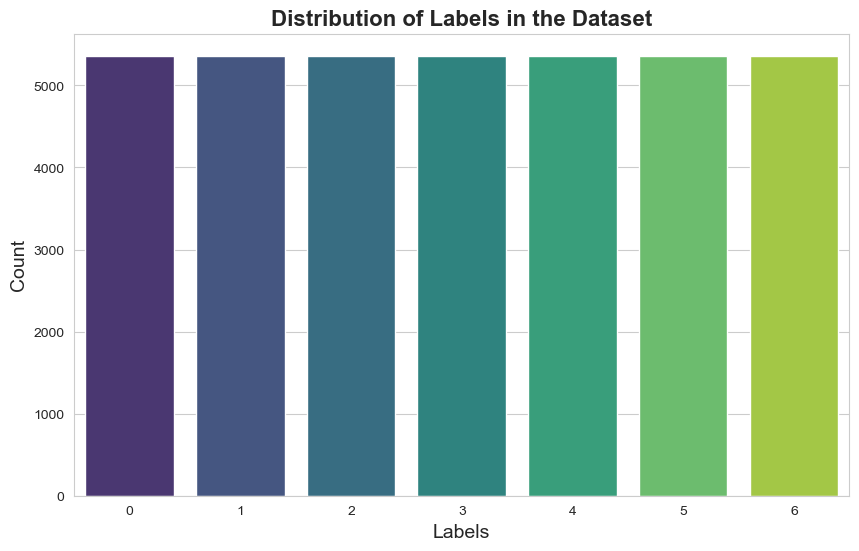

In [19]:
# Visualizing the balanced class distribution.
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train, palette="viridis")
plt.title("Distribution of Labels in the Dataset", fontsize=16, weight='bold')
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

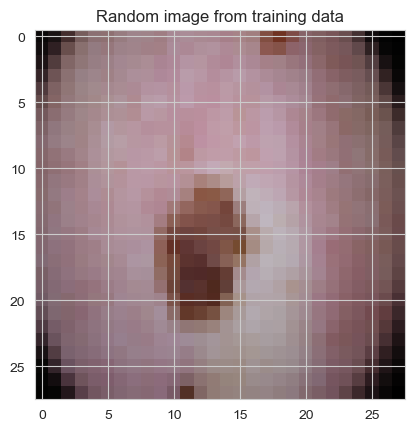

In [20]:
# Visualizing random samples from the training data.
import matplotlib.pyplot as plt
import random
num = random.randint(0, 8000)  # Selecting a random index.
x_train = np.array(x_train, dtype=np.uint8).reshape(-1, 28, 28, 3)  # Reshaping features for image display.

plt.imshow(x_train[num].reshape(28, 28, 3))  # Displaying a random image.
plt.title("Random image from training data")
plt.show()

# Step 5: Model Building (CNN)

In [21]:
from tensorflow.keras.models import Sequential  # Importing Sequential API for model building.
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D  # Importing required layers.
import tensorflow as tf  # Importing TensorFlow for deep learning tasks.


In [22]:
# Initialize a Sequential model, which represents a linear stack of layers.
model = Sequential()

# Add a 2D convolutional layer with 16 filters, each of size 3x3.
# 'relu' activation function is used to introduce non-linearity.
# The 'same' padding ensures the output size matches the input size.
# The input shape is 28x28 pixels with 3 channels (RGB).
model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 3), activation='relu', padding='same'))

# Add a 2D max-pooling layer with a pool size of 2x2.
# This reduces the spatial dimensions (height and width) of the output.
model.add(MaxPool2D(pool_size=(2, 2)))

# Add a batch normalization layer to standardize the output of the previous layer.
# This helps in faster convergence and stabilizes the learning process.
model.add(tf.keras.layers.BatchNormalization())

# Add another convolutional layer with 32 filters of size 3x3 and ReLU activation.
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Add another convolutional layer with 64 filters of size 3x3 and ReLU activation.
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Add another max-pooling layer with a pool size of 2x2.
model.add(MaxPool2D(pool_size=(2, 2)))

# Add another batch normalization layer.
model.add(tf.keras.layers.BatchNormalization())

# Add another convolutional layer with 128 filters of size 3x3 and ReLU activation.
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))

# Add another convolutional layer with 256 filters of size 3x3 and ReLU activation.
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))

# Flatten the 3D feature maps from the convolutional layers into a 1D vector for input to the fully connected layers.
model.add(Flatten())

# Add a dropout layer with a dropout rate of 0.2 to prevent overfitting.
model.add(tf.keras.layers.Dropout(0.2))

# Add a fully connected dense layer with 256 units and ReLU activation.
model.add(Dense(256, activation='relu'))

# Add another batch normalization layer.
model.add(tf.keras.layers.BatchNormalization())

# Add another dropout layer with a dropout rate of 0.2.
model.add(tf.keras.layers.Dropout(0.2))

# Add another fully connected dense layer with 128 units and ReLU activation.
model.add(Dense(128, activation='relu'))

# Add another batch normalization layer.
model.add(tf.keras.layers.BatchNormalization())

# Add another fully connected dense layer with 64 units and ReLU activation.
model.add(Dense(64, activation='relu'))

# Add another batch normalization layer.
model.add(tf.keras.layers.BatchNormalization())

# Add another dropout layer with a dropout rate of 0.2.
model.add(tf.keras.layers.Dropout(0.2))

# Add a fully connected dense layer with 32 units and ReLU activation.
model.add(Dense(32, activation='relu'))

# Add another batch normalization layer.
model.add(tf.keras.layers.BatchNormalization())

# Add the final output layer with 7 units (one for each class), using softmax activation.
# The softmax activation is used for multi-class classification, as it converts raw output into probabilities.
model.add(Dense(7, activation='softmax'))

# Display the model architecture (summary of layers, parameters, etc.).
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           23

 Total params: 504,103 (1.92 MB)

 Trainable params: 502,983 (1.92 MB)

 Non-trainable params: 1,120 (4.38 KB)

# Step 6: Setting Optimizer & Annealing

In [23]:
# Defining a callback to save the best model based on validation accuracy.
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',  # Specifies the file path where the best model will be saved.
    monitor='val_acc',  # The metric to monitor, in this case, validation accuracy.
    mode='max',  # Specifies that we want to maximize the monitored metric (validation accuracy).
    verbose=1,  # Prints information to the console when the model is saved.
    save_best_only=True  # Only saves the model when it achieves a new best validation accuracy.
)

# Set the optimizer to Adam with a learning rate of 0.001.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Adam optimizer is commonly used due to its adaptive learning rate and good performance in many tasks.

# Compile the model by specifying the loss function, optimizer, and metrics to track during training.
model.compile(
    loss='sparse_categorical_crossentropy',  # The loss function for multi-class classification with integer labels.
    optimizer=optimizer,  # The optimizer used to minimize the loss function.
    metrics=['accuracy']  # Specifies that accuracy will be tracked during training.
)



# Step 7: Fitting the model

In [24]:
from datetime import datetime

start_time = datetime.now() # Records the start time of training.

history = model.fit(x_train, y_train, validation_split=0.2, batch_size=128, epochs=50, shuffle=True, callbacks=[callback])
# Trains the model on the training data, with 20% used for validation.

end_time = datetime.now()  # Records the end time of training.
print('Duration: {}'.format(end_time - start_time)) # Prints the training duration.


Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.4106 - loss: 1.6060 - val_accuracy: 0.1324 - val_loss: 2.6744
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8364 - loss: 0.4944 - val_accuracy: 0.2840 - val_loss: 1.9445
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9056 - loss: 0.2828 - val_accuracy: 0.4271 - val_loss: 1.1960
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9271 - loss: 0.2139 - val_accuracy: 0.4913 - val_loss: 1.1322
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9435 - loss: 0.1692 - val_accuracy: 0.7224 - val_loss: 0.6758
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9460 - loss: 0.1523 - val_accuracy: 0.7261 - val_loss: 0.5665
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9633 - loss: 0.1047 - val_accuracy: 0.7939 - val_loss: 0.5356
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9646 - loss: 0.1000 - val_accu

# Step 8: Model Evaluation

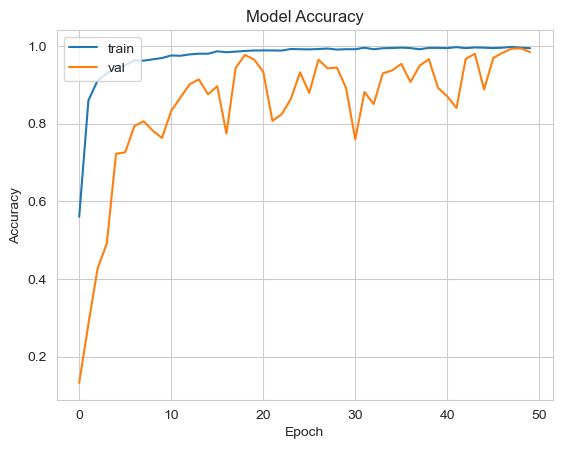

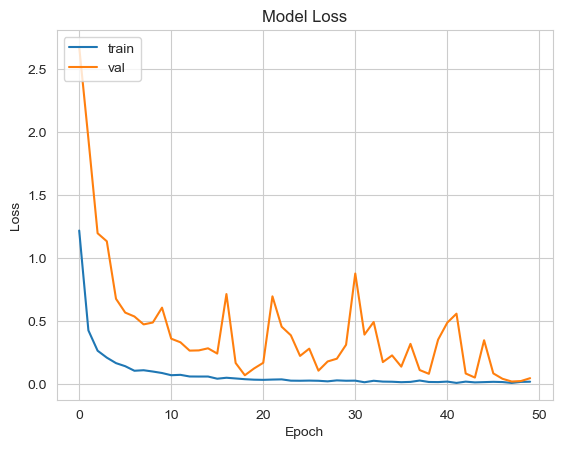

In [25]:
plt.plot(history.history['accuracy']) # Plots training accuracy.
plt.plot(history.history['val_accuracy']) # Plots validation accuracy.
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) # Plots training loss.
plt.plot(history.history['val_loss']) # Plots validation loss.
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [26]:
# Loading the best model and evaluating its performance on the test set.
model.load_weights('best_model.h5') # Loads the best weights saved during training.

x_test = np.array(x_test).reshape(-1, 28, 28, 3)
# Reshapes the test data into the required format.

loss, acc = model.evaluate(x_test, y_test, verbose=2)
# Evaluates the model's performance on the test data.


63/63 - 0s - 5ms/step - accuracy: 0.9486 - loss: 0.2426


# Step 9: Confusion Matrix

In [27]:
# Generating predictions and confusion matrix.
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)  # Predicts the class probabilities for the test data.
y_pred = np.argmax(y_pred, axis=1)  # Converts probabilities into class labels.

conf_mat = confusion_matrix(y_test, y_pred)  # Generates a confusion matrix.
print(conf_mat)  # Displays the confusion matrix.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[  54    1    2    1    2    0    0]
 [   0  108    2    0    1    0    1]
 [   1    2  224    0   10    0    2]
 [   0    0    1   23    1    0    0]
 [   1    8   16    1 1300    1   16]
 [   0    0    1    0    1   24    0]
 [   1    1   12    0   17    0  167]]


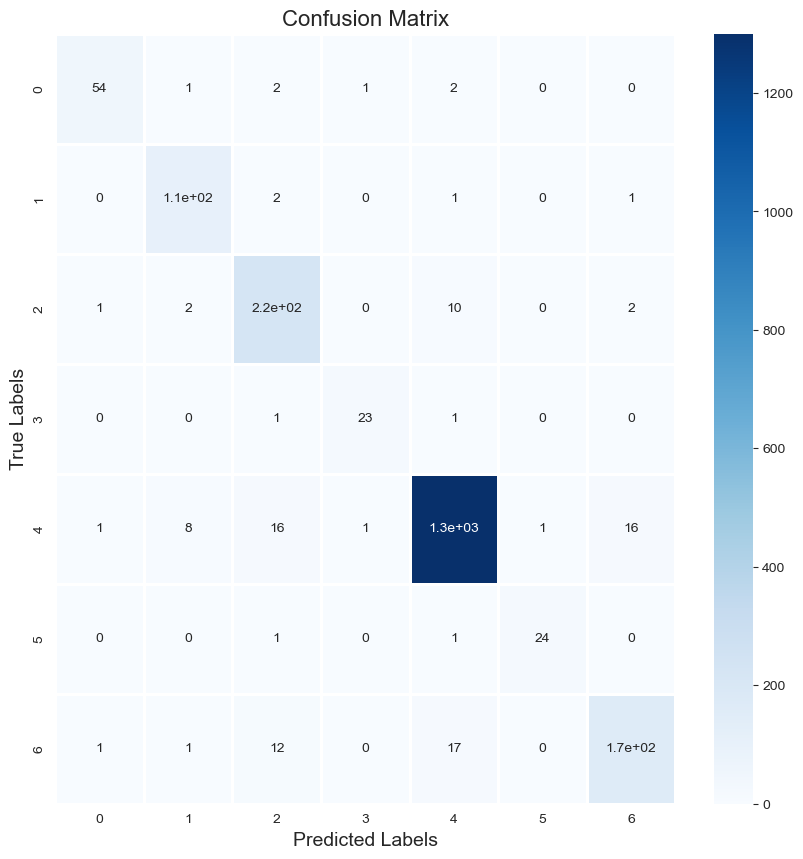

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
# Creates a new figure and axes for plotting with a specified size of 10x10 inches.

# Plots a heatmap of the confusion matrix.
ax = sns.heatmap(
    conf_mat,  # The confusion matrix data to plot.
    annot=True,  # Annotates each cell with its numeric value.
    cmap='Blues',  # Sets the color map to 'Blues' for a blue color gradient.
    linewidths=.9,  # Sets the width of the lines separating the cells in the heatmap.
    ax=ax  # Specifies the axes object to plot the heatmap on.
)

# Sets the title of the heatmap plot with a specific font size.
ax.set_title('Confusion Matrix', fontsize=16)

# Sets the label for the x-axis (Predicted labels) with a specific font size.
ax.set_xlabel('Predicted Labels', fontsize=14)

# Sets the label for the y-axis (True labels) with a specific font size.
ax.set_ylabel('True Labels', fontsize=14)

# Displays the plot on the screen.
plt.show()


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 1. Make Predictions
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predictions to class indices

# 2. Calculate Precision, Recall, and F1-Score for each class
precision = precision_score(y_test, y_pred, average=None)  # per class
recall = recall_score(y_test, y_pred, average=None)  # per class
f1 = f1_score(y_test, y_pred, average=None)  # per class

# 3. Print Precision, Recall, and F1-Score for each class
print("Precision for each class:", precision)
print("Recall for each class:", recall)
print("F1-Score for each class:", f1)

# 4. Print the overall classification report (includes precision, recall, f1-score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5. Optionally, you can calculate the weighted or macro average for each metric
precision_avg = precision_score(y_test, y_pred, average='weighted')  # Weighted average
recall_avg = recall_score(y_test, y_pred, average='weighted')  # Weighted average
f1_avg = f1_score(y_test, y_pred, average='weighted')  # Weighted average

print(f"\nWeighted Precision: {precision_avg}")
print(f"Weighted Recall: {recall_avg}")
print(f"Weighted F1-Score: {f1_avg}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precision for each class: [0.94736842 0.9        0.86821705 0.92       0.97597598 0.96
 0.89784946]
Recall for each class: [0.9        0.96428571 0.93723849 0.92       0.96798213 0.92307692
 0.84343434]
F1-Score for each class: [0.92307692 0.93103448 0.90140845 0.92       0.97196262 0.94117647
 0.86979167]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92        60
           1       0.90      0.96      0.93       112
           2       0.87      0.94      0.90       239
           3       0.92      0.92      0.92        25
           4       0.98      0.97      0.97      1343
           5       0.96      0.92      0.94        26
           6       0.90      0.84      0.87       198

    accuracy                           0.95      2003
   macro avg       0.92      0.92      0.92      2003
weighted avg       0.95      0.95      0.95      2003


Weighted Precision: 0.94938387

In [42]:
import PIL  # Importing the Python Imaging Library (PIL) for image processing

# Open an image file from the given path
image = PIL.Image.open('/Users/sakshizanjad/Downloads/Skin cancer detection AIML project/tester.jpg')

# Resize the opened image to 28x28 pixels, typically to match the input size for the model
image = image.resize((28, 28))

# This line seems unnecessary as you're not using 'x_test[1]' here. It assigns a sample from 'x_test' to 'img'.
# This would typically be used if you're testing the model on a specific dataset (e.g., testing or validation set).
# Commenting this out as it's overwritten in the next step
# img = x_test[1]

# Convert the resized image to a numpy array, which is a common format for input to deep learning models
# The reshaping ensures the array is in the correct shape: (-1, 28, 28, 3)
# '-1' automatically infers the batch size (1 in this case, since we're processing one image)
# '28x28' is the image size, and '3' represents the 3 color channels (RGB)
img = np.array(image).reshape(-1, 28, 28, 3)

# Use the trained model to predict the class of the image
# The model will output class probabilities or logits for each class
result = model.predict(img)

# Print the result (probabilities/logits) for the first image in the batch
# This will show the predicted values for each class
print(result[0])

# Convert the result to a list for easier manipulation (if it's in a NumPy array format initially)
result = result.tolist()

# Find the maximum probability from the prediction result, which corresponds to the predicted class
max_prob = max(result[0])

# Get the index of the class with the highest probability
class_ind = result[0].index(max_prob)

# Print the class label that corresponds to the index of the maximum probability
# 'classes' is assumed to be a predefined list that contains the class labels
print(classes[class_ind])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[3.0883457e-05 2.6090082e-04 1.1871214e-03 8.5738473e-05 9.9329466e-01
 5.8385976e-05 5.0822566e-03]
('nv', 'melanocytic nevi')
